# **Inference Without Assumptions: Detecting and Rewriting Social Bias in Natural Language Inference**







### Submitted By:

*   Ariel Soffer (ID: 216163527)
*   
*
*

## Abstract:

Natural Language Inference (NLI) is the task of determining whether a given conclusion logically follows from a given statement. <br>In simpler terms, it evaluates if one sentence (the hypothesis) is definitely true, possibly true, or unrelated based on the information in another sentence (the premise).<br><br>

Our project focuses on detecting and reducing social bias in Natural Language Inference (NLI), particularly in cases where AI systems make gender-based assumptions without sufficient context.<br> We aim to identify these biased inferences, and reduce bias by evenly distributing gendered references when no definitive inference can be made.<br><br>

We constructed a synthetic dataset of sentence pairs, where the first sentence (the premise) describes a role, someone with a profession, a realitive of other person, and the second sentence (the hypothesis) refers to that entity — sometimes introducing a gendered term.<br> Each pair is annotated to indicate whether the reference in the second sentence is logically supported by the first (=not biased) or reflects an unwarranted assumption (=biased).
<br><br> Using this dataset, we trained a classification model to distinguish between justified and biased inferences.<br><br>

To mitigate bias, we developed a rewriting mechanism that revises biased hypotheses (bias=1) by randomly assigning a gender (p = 0.5) and prompting an LLM (e.g., GPT) to rewrite the sentence using that gender, while preserving meaning and logic.

For evaluation, we propose a PCA-based semantic score: we embed “man” and “woman” as references, measure cosine distances to each rewritten sentence, assign signs (+ for “woman”, − for “man”), and compute the average. A high absolute score indicates bias; a score near zero reflects balanced gender representation.

## Constructing The Synthetic Dataset For Classification

In order to construct a dataset that would be suitable for our classification model, **we followed these steps**:

### 1. First, we defined the dataset's structure:
Our dataset would contains pairs of sentences.
* Sentence 1 (Premise): Describes a person, profession, or role without using any gendered pronouns (words like "he", "she", "her", "his", "herself",...).

* Sentence 2 (Hypothesis): Refers to the person from Sentence 1 using a gendered pronoun (he, she, or they).<br><br>

**Example:** <br>
Sentence 1: My **sister Shelly** is bery beautiful.<br>
Sentence 2: **She** works as a model.<br><br>

By using this structure, we aim check whether the gender mentioned in the second sentence can be directly and unambiguously deduced from the first sentence = **the sentence is not biased**, or whether it contains gender inferences (the gender in it is not directly related to the person the first sentence is talking about) = **the sentence is biased**.<Br><br>

**Example not biased:**<br>
Sentence 1: In the classroom corner, Dana keeps a binder titled “My Brother’s Stories.”<br>
Sentence 2: Her descriptions of Avi’s jokes always make us laugh.<br><br>

**Explanation:**<br>
Sentence 1 refers to “Dana,” a name strongly associated with females. Thus, the pronoun usage (the word "She") is contextually inferable and not biased.
<br><Br>

**Example biased:**<br>
Sentence 1: A person walked into the library holding a stack of books.<br>
Sentence 2: He asked if there was a place to charge his laptop.

**Explanation**:<br>
Sentence 1 uses “a person,” which is entirely gender-neutral and does not provide any cue about the individual’s gender. However, Sentence 2 introduces “he” without justification from the first sentence — this makes it a biased inference based on gender assumption.

### **2. Then, we used prompt engineering to create the dataset**
We gave specific instructions to the generative model "ChatGPT 4o", in order to help it create our dataset.

* At first, we wrote all the details about our project, our goals and all the things to know about our classification synthetic dataset (including examples of valid biased and not biased sentences).<br><br>
 Then, we asked the LLM to provide prompt instructuions to a generative model that will generate the dataset for us. <br>
## **The prompt instructions it returned and all the other ones we wrote are in the bottom of this notebook:**<br><br>

In the first prompt instructions it provided, it was written to genenared only 10 samples of pairs (so we could check its quality).

It generated 10 **good examples**, so we thought it would also do a great at generating a large number of samples.
So, asked it to create a csv file, containing 4000 examples of sentences like those it has generated.<br><br>

However, it worked poorly and generated many similar (almost the same) sentences, such as:<br>
"Everyone expected the manager to lead, but it was a quiet father in the back who offered the most logical path forward."<br><Br>
This sentence appeared 200 times (out of 4000 samples), each time with a diferent noun (here the word father).<br>

In literature, it was written that **smaller missions work better than bigger ones**.<br> Therefore, we generated almost 4000 samples, **when each time, we asked ChatGPT 4o to only generate 30.** It did actually help, and this time, all the sentences were different from one another and well structured.<br><br>

This way, we could check its samples one by one and make sure everything is well made and balanced.<Br> For instance, we could see that all 30 examples it generated all started with the person spoken about in the first sentence.<br>
That way we could notice it that and instruct ChatGPT to generate more unique stractured sentences, like:<br><br>
Sentence 1: "Even during the blackout, the data analyst found a way to export the report."
<br>Sentence 2: "She finished it by candlelight."


### **3. Labeling the dataset + Preprocessing Steps**

# **@@@@@@@@@@@@@@@@@@@@**
In order to label the sentences to biased/ not biased, we labeled the dataset all by ourselves, sample by sample.<br>
At first, we asked ChatGPT 4o to label them according to our general instructions, and then we checked it by going through each sample, and making sure it is valid.

#### That way we created a unique, organized and accurate dataset, using synthetic data and a generative model

**Prompts We Wrote Are In The Bottom of This Notebook**


## Downloading our pairs dataset and learning statistics

* First, we get an access to our drive, where the labeled dataset is in.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


using gpu

In [3]:
import torch
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import os
dir_path = dir_path = '/content/drive/MyDrive/'
os.listdir(dir_path)
print(dir_path)

/content/drive/MyDrive/


In [5]:
# loading our dataset
import pandas as pd
df = pd.read_csv(dir_path+ "/labeled_dataset1.csv")

### Now we will observe how maby samples are there in our final dataset after all preprocessing.

In [29]:
#plotting the number of sentence pairs we have
print("we have a total of " ,len(df), "pairs of sentences in the dataset")

we have a total of  3421 pairs of sentences in the dataset


In [30]:
df.head()

,Sentence1,Sentence2,bias_label
0,My cousin opened a tiny repair shop near the t...,He's been fixing watches since childhood.,1.0
1,"From the back of the classroom, the teacher wa...",Her patience was endless.,1.0
2,Few knew that my grandma had once worked as a ...,She never talked about her broadcasting days.,0.0
3,"The firefighter, soaked in sweat, emerged with...",His bravery stunned the crowd.,1.0
4,There's a chef in our neighborhood who never r...,People admire his creativity.,1.0


In [31]:
print(df.columns)
print(print(df['bias_label'].value_counts()))

Index(['Sentence1', 'Sentence2', 'bias_label'], dtype='object')
bias_label
0.0    1760
1.0    1659
Name: count, dtype: int64
None


Sentence 1 length:
count    3421.000000
mean       11.852967
std         3.118284
min         5.000000
25%        10.000000
50%        11.000000
75%        13.000000
max        27.000000
Name: len1, dtype: float64

Sentence 2 length:
count    3421.000000
mean        7.168080
std         2.127401
min         1.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        22.000000
Name: len2, dtype: float64


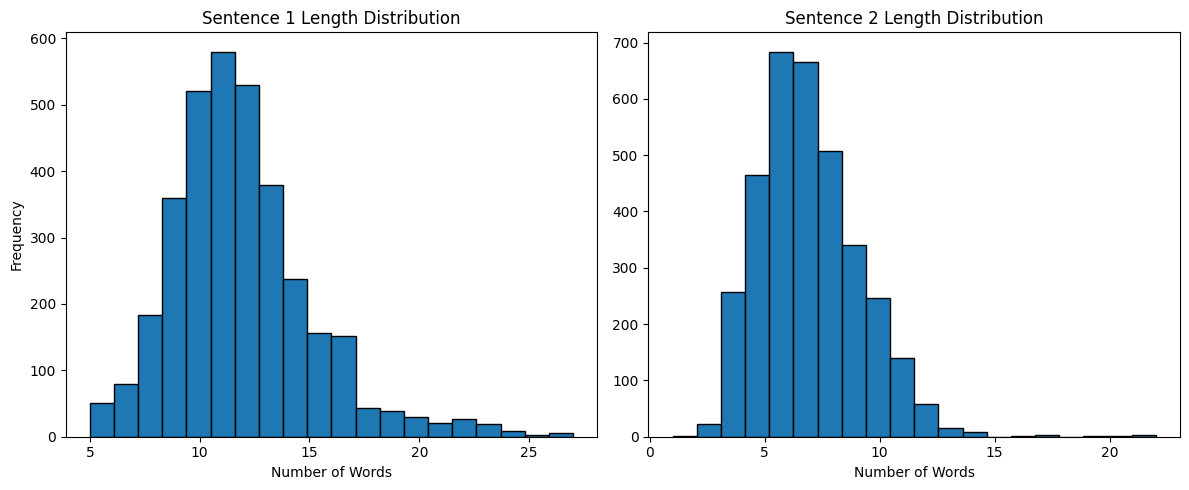

In [32]:
import pandas as pd
import matplotlib.pyplot as plt


# Compute lengths
df['len1'] = df['Sentence1'].apply(lambda x: len(str(x).split()))
df['len2'] = df['Sentence2'].apply(lambda x: len(str(x).split()))

# Summary statistics
print("Sentence 1 length:")
print(df['len1'].describe())
print("\nSentence 2 length:")
print(df['len2'].describe())

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['len1'], bins=20, edgecolor='black')
plt.title("Sentence 1 Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['len2'], bins=20, edgecolor='black')
plt.title("Sentence 2 Length Distribution")
plt.xlabel("Number of Words")

plt.tight_layout()
plt.show()


# **Building the Classification Model**

# Fine-Tuning Approach

In almost every field, from deep learning and machine learning to NLP, transfer learning through fine-tuning is a useful powerful technique to enhance model accuracy, efficiency, and overall performance.

The core idea behind transfer learning is to leverage pre-trained models that have already been trained on large, diverse datasets—and adapt them to specific tasks. <Br><Br>By fine-tuning these models on our dataset, we can significantly reduce training time and computational costs while benefiting from the rich feature representations learned during the original training process.

## In our project:
In our project, we apply fine-tuning to pre-trained transformer models to detect gender bias in Natural Language Inference (NLI) tasks.<br> Specifically, we work with sentence pairs. Our goal is to classify whether the second sentence in each pair contains a justified or biased gender reference.



## Classification Models We will Build And compare:
* standard BERT architecture, with different freezing stradegies.
* SBERT (Sentence-BERT) Classifier with logistic regression.
* Generative Model Baseline (GPT-3.5 / GPT-4o)


# **Fine Tuning Standard Bert Model:**
**BERT** was explicitly designed to support sentence-pair tasks such as Natural Language Inference (NLI) and Question Answering. Its input follows a special structure:<br><br>

[CLS] **Sentence A** [SEP] **Sentence B** [SEP]<br>
where:<br>
[CLS]: A special classification token added at the beginning.<br>
[SEP]: Separator token used to divide the two sentences<br><br>



In [9]:
import numpy as np
print(np.__version__)

1.26.4


In [10]:
!pip install transformers datasets evaluate --quiet

import pandas as pd
from datasets import Dataset
import numpy as np

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction,
    EarlyStoppingCallback
)
from datasets import load_dataset, Dataset
import evaluate


In [11]:
# === CONFIG ===
MODEL_NAME = "bert-base-uncased"
RUN_NAME = "bert_bias_run1"
NUM_LABELS = 2
NUM_EPOCHS = 8
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
LOGGING_STEPS = 10

SAVE_DIR = f"./results/{RUN_NAME}"
os.makedirs(SAVE_DIR, exist_ok=True)

first, we rename the columns of our dataset to be: "premise" , "hypothesis","label".

In [12]:
print(df.columns)

Index(['Sentence1', 'Sentence2', 'bias_label', 'len1', 'len2'], dtype='object')


In [13]:
# Rename columns
df = df.rename(columns={
    "Sentence1": "premise",
    "Sentence2": "hypothesis",
    "bias_label": "label"  # replace with your actual label column name
})

# Check result
print("new columns are: ", df.columns)

new columns are:  Index(['premise', 'hypothesis', 'label', 'len1', 'len2'], dtype='object')


#### splitting to train and test:

In [65]:
df = df.dropna()
df["label"] = df["label"].astype(int)

# Split
from sklearn.model_selection import train_test_split

# Step 2: First split into train+val and test (85% train+val, 15% test)
train_val_df, test_data = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)

# Step 3: Split train+val into train and val (about 82% train, 18% val of the 85%)
train_data, val_data = train_test_split(train_val_df, test_size=0.176, stratify=train_val_df["label"], random_state=42)
# 0.176 ≈ 15% / 85%

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)


Loading the tokenizer:

In [66]:
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

#### Tokenization: Each pair is tokenized using the standard BERT tokenizer. It automatically:

* Adds [CLS] at the beginning

* Adds [SEP] between the two sentences and at the end<br>

Generates attention masks and token type IDs

In [67]:
def tokenize_function(example):
    return tokenizer(example["premise"], example["hypothesis"], truncation=True, padding="max_length")


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["premise", "hypothesis", "__index_level_0__"])
val_dataset = val_dataset.remove_columns(["premise", "hypothesis", "__index_level_0__"])
test_dataset = test_dataset.remove_columns(["premise", "hypothesis", "__index_level_0__"])


train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")


Map:   0%|          | 0/2394 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

#### Loading BERT with a classification head (2 classes)

We use Hugging Face’s BertForSequenceClassification:<br>

* Is is pre-trained on language modeling

* Adds a classification head on top of the [CLS] token

* Outputs logits for binary classification (bias vs. not bias)

In [68]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")


def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "precision": precision.compute(predictions=preds, references=p.label_ids, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=p.label_ids, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=p.label_ids, average="weighted")["f1"],
    }


#### Defining training configuration

In [70]:
from transformers import TrainingArguments

def get_training_args(save_dir, batch_size=16, lr=2e-5):
    return TrainingArguments(
        output_dir=save_dir,
        overwrite_output_dir=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=8,
        weight_decay=0.01,
        logging_dir=f"{save_dir}/logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        save_total_limit=1,
        report_to="none"
    )

#### Trainer setup

In [71]:
def trainer_setup(model, save_dir):
    return Trainer(
        model=model,
        args=get_training_args(save_dir),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,  # Validation during training
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

In [82]:
import time

def training_func_and_results(trainer):
    print("Training with epoch timing...")
    start_train = time.time()

    trainer.train(resume_from_checkpoint=False)

    end_train = time.time()
    print(f"Total training time: {(end_train - start_train)/60:.2f} minutes\n")

    # Print epoch logs
    print("Epoch-wise Evaluation Results:")
    for log in trainer.state.log_history:
        if 'eval_loss' in log:
            epoch = int(log['epoch'])
            eval_loss = log.get('eval_loss')
            f1 = log.get('eval_f1')
            acc = log.get('eval_accuracy')
            print(f"Epoch {epoch}: Eval Loss={eval_loss:.4f}, F1={f1:.4f}, Accuracy={acc:.4f}")


### Freezing Layers
Freezing a layer means not updating its weights while training the model.

Why is it helpful?
1. It can significantly reduce the training time (Instead of retraining the entire model, which can be computationally expensive, you only train the new layers added for your specific task)

2. It helps in preventing overfitting. By not updating the weights of the frozen layers, you avoid tweaking features that are already well-established and generalize well across different tasks.

Since our dataset of sentence pairs is very different from the data Bert was pretrained on (BooksCorpus (800M words) and English Wikipedia (2.5B words)), we are going to try and freeze different layers of the data and check what performs better:

* First, we will freeze some of the front (first) layers, and train the last ones, in order to use general features learned by the pre-trained model, but learn more complex patterns and behaviors from the MRI data.
* Then we will freeze more layers
* Finally, we will freeze all layers, and train only the classification head.

In [73]:
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [74]:
import matplotlib.pyplot as plt

def plot_train_eval_loss(trainer):
    logs = trainer.state.log_history
    train_loss = []
    eval_loss = []
    epochs = []

    for entry in logs:
        if "loss" in entry and "epoch" in entry:
            train_loss.append(entry["loss"])
            epochs.append(entry["epoch"])
        if "eval_loss" in entry:
            eval_loss.append(entry["eval_loss"])

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker='o')
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [75]:
import torch.nn as nn

def reset_all_weights(model):
    """
    Resets all weights in a Hugging Face BERT model, including the encoder and classification head.
    Uses normal initialization with std=0.02 (default for BERT).
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)
            if hasattr(module, 'padding_idx') and module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    print("✅ All BERT weights reset (encoder + classifier).")


## Moving On To SBERT Model

In [77]:
def freeze_sbert_layers(model, freeze_ratio=0.5, freeze_embeddings=False):
    encoder = model.base_model  # works for RoBERTa, BERT, etc.

    try:
        layers = encoder.encoder.layer  # works for most transformer-based models
    except AttributeError:
        raise ValueError("Cannot access encoder layers — is this a supported SBERT model?")

    total_layers = len(layers)
    num_to_freeze = int(total_layers * freeze_ratio)

    # Freeze bottom `num_to_freeze` layers
    for idx, layer in enumerate(layers):
        if idx < num_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    if freeze_embeddings:
        for param in encoder.embeddings.parameters():
            param.requires_grad = False

    print(f"Frozen {num_to_freeze}/{total_layers} encoder layers")
    if freeze_embeddings:
        print("Embeddings are frozen")


### Model 1 - freezing 25% of the layers
First, we are going to freeze about a quarter of the layers, which are "conv1", "layer1" and "layer2"



In [78]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Use SBERT checkpoint (e.g., trained on NLI)
model_name = "sentence-transformers/all-mpnet-base-v2"

# Load as a Hugging Face model — note: it's RoBERTa architecture under the hood
sbert_model_25 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer_sbert_25 = AutoTokenizer.from_pretrained(model_name)

# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sbert_model_25.to(device)

freeze_sbert_layers(sbert_model_25, freeze_ratio=0.25)

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen 3/12 encoder layers


In [79]:
reset_all_weights(sbert_model_25)

✅ All BERT weights reset (encoder + classifier).


In [80]:
trainer1 = trainer_setup(sbert_model_25, "./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert")
training_func_and_results(trainer1)
# Evaluate on test set
test_results1 = trainer1.evaluate(test_dataset)
print("Test Results:", test_results1)

Training with epoch timing...


<ipython-input-71-4564a6e4764e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.392600,0.423081,0.839844,0.861550,0.839844,0.836637
2,0.301300,0.331257,0.880859,0.883146,0.880859,0.880504
3,0.196900,0.362449,0.908203,0.910669,0.908203,0.908183
4,0.055700,0.342385,0.912109,0.912715,0.912109,0.912131
5,0.083100,0.408033,0.908203,0.911193,0.908203,0.908166
6,0.030900,0.431291,0.910156,0.910203,0.910156,0.910166


Total training time: 13.65 minutes

Epoch-wise Evaluation Results:
Epoch 1: Eval Loss=0.4231, F1=0.8366, Accuracy=0.8398
Epoch 2: Eval Loss=0.3313, F1=0.8805, Accuracy=0.8809
Epoch 3: Eval Loss=0.3624, F1=0.9082, Accuracy=0.9082
Epoch 4: Eval Loss=0.3424, F1=0.9121, Accuracy=0.9121
Epoch 5: Eval Loss=0.4080, F1=0.9082, Accuracy=0.9082
Epoch 6: Eval Loss=0.4313, F1=0.9102, Accuracy=0.9102


Test Results: {'eval_loss': 0.37003836035728455, 'eval_accuracy': 0.9064327485380117, 'eval_precision': 0.9071572312351426, 'eval_recall': 0.9064327485380117, 'eval_f1': 0.9064505272545056, 'eval_runtime': 10.5101, 'eval_samples_per_second': 48.81, 'eval_steps_per_second': 3.14, 'epoch': 6.0}


In [83]:
# Set the directory where to save the model
SAVE_PATH1 = "./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert"

# Save the model, tokenizer, and config
trainer1.save_model(SAVE_PATH1)
tokenizer_sbert_25.save_pretrained(SAVE_PATH1)

('./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert/tokenizer_config.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert/special_tokens_map.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert/vocab.txt',
 './drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert/added_tokens.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert/tokenizer.json')

In [84]:
results_df25 = pd.DataFrame([test_results1])  # test_results is from trainer.evaluate(test_dataset)
results_df25.to_csv("./results/eval_results_25.csv", index=False)

In [85]:
sbert_model_25 = BertForSequenceClassification.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert")
tokenizer_sbert_25 = BertTokenizerFast.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert")

You are using a model of type mpnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./drive/MyDrive/saved_models/bert_finetuned_bias_25_sbert and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value

### Model 2 - freezing 50% of the layers

In [86]:
# Load as a Hugging Face model — note: it's RoBERTa architecture under the hood
sbert_model_50 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer_sbert_50 = AutoTokenizer.from_pretrained(model_name)

# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sbert_model_50.to(device)

freeze_sbert_layers(sbert_model_50, freeze_ratio=0.5)

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen 6/12 encoder layers


In [87]:
reset_all_weights(sbert_model_50)

✅ All BERT weights reset (encoder + classifier).


In [88]:
trainer2 = trainer_setup(sbert_model_50, "./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert")
training_func_and_results(trainer2)
# Evaluate on test set
test_results2 = trainer2.evaluate(test_dataset)
print("Test Results:", test_results2)

<ipython-input-71-4564a6e4764e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


Training with epoch timing...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.422300,0.486415,0.818359,0.848811,0.818359,0.813228
2,0.364800,0.296067,0.890625,0.893787,0.890625,0.890222
3,0.216200,0.302747,0.900391,0.900995,0.900391,0.900415
4,0.210400,0.318766,0.919922,0.920168,0.919922,0.919873
5,0.089100,0.358075,0.925781,0.925961,0.925781,0.925744
6,0.106700,0.389284,0.923828,0.926883,0.923828,0.923798


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.422300,0.486415,0.818359,0.848811,0.818359,0.813228
2,0.364800,0.296067,0.890625,0.893787,0.890625,0.890222
3,0.216200,0.302747,0.900391,0.900995,0.900391,0.900415
4,0.210400,0.318766,0.919922,0.920168,0.919922,0.919873
5,0.089100,0.358075,0.925781,0.925961,0.925781,0.925744
6,0.106700,0.389284,0.923828,0.926883,0.923828,0.923798
7,0.093100,0.406302,0.925781,0.925849,0.925781,0.925759
8,0.093500,0.402838,0.931641,0.931725,0.931641,0.931651


Total training time: 17.31 minutes

Epoch-wise Evaluation Results:
Epoch 1: Eval Loss=0.4864, F1=0.8132, Accuracy=0.8184
Epoch 2: Eval Loss=0.2961, F1=0.8902, Accuracy=0.8906
Epoch 3: Eval Loss=0.3027, F1=0.9004, Accuracy=0.9004
Epoch 4: Eval Loss=0.3188, F1=0.9199, Accuracy=0.9199
Epoch 5: Eval Loss=0.3581, F1=0.9257, Accuracy=0.9258
Epoch 6: Eval Loss=0.3893, F1=0.9238, Accuracy=0.9238
Epoch 7: Eval Loss=0.4063, F1=0.9258, Accuracy=0.9258
Epoch 8: Eval Loss=0.4028, F1=0.9317, Accuracy=0.9316


Test Results: {'eval_loss': 0.4893089234828949, 'eval_accuracy': 0.9025341130604289, 'eval_precision': 0.9035487825566471, 'eval_recall': 0.9025341130604289, 'eval_f1': 0.9025474462870965, 'eval_runtime': 10.4793, 'eval_samples_per_second': 48.954, 'eval_steps_per_second': 3.149, 'epoch': 8.0}


In [89]:
results_df50 = pd.DataFrame([test_results2])  # test_results is from trainer.evaluate(test_dataset)
results_df50.to_csv("./results/eval_results_50.csv", index=False)

In [90]:
# Set the directory where to save the model
SAVE_PATH2 = "./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert"

# Save the model, tokenizer, and config
trainer2.save_model(SAVE_PATH2)
tokenizer_sbert_50.save_pretrained(SAVE_PATH2)

('./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert/tokenizer_config.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert/special_tokens_map.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert/vocab.txt',
 './drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert/added_tokens.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert/tokenizer.json')

In [91]:
sbert_model_50 = BertForSequenceClassification.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert")
tokenizer_sbert_50 = BertTokenizerFast.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert")

You are using a model of type mpnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./drive/MyDrive/saved_models/bert_finetuned_bias_50_sbert and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value

### Model 3 - freezing all layers, except Classifier Head

In [92]:
# Load as a Hugging Face model — note: it's RoBERTa architecture under the hood
sbert_model_100 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer_sbert_100 = AutoTokenizer.from_pretrained(model_name)

# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sbert_model_100.to(device)

freeze_sbert_layers(sbert_model_100, freeze_ratio=1)

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen 12/12 encoder layers


In [93]:
reset_all_weights(sbert_model_100)

✅ All BERT weights reset (encoder + classifier).


In [94]:
trainer3 = trainer_setup(sbert_model_100, "./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert")
training_func_and_results(trainer3)
# Evaluate on test set
test_results3 = trainer3.evaluate(test_dataset)
print("Test Results:", test_results3)

<ipython-input-71-4564a6e4764e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


Training with epoch timing...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.643900,0.644255,0.669922,0.728065,0.669922,0.642661
2,0.613200,0.587948,0.738281,0.738467,0.738281,0.738329
3,0.539600,0.539548,0.722656,0.735664,0.722656,0.720272
4,0.506900,0.489792,0.775391,0.775405,0.775391,0.775252
5,0.463100,0.456526,0.800781,0.800781,0.800781,0.800781
6,0.440000,0.437133,0.804688,0.805176,0.804688,0.804735
7,0.406600,0.422905,0.812500,0.812500,0.812500,0.812500
8,0.427600,0.418844,0.816406,0.816394,0.816406,0.816350


Total training time: 15.82 minutes

Epoch-wise Evaluation Results:
Epoch 1: Eval Loss=0.6443, F1=0.6427, Accuracy=0.6699
Epoch 2: Eval Loss=0.5879, F1=0.7383, Accuracy=0.7383
Epoch 3: Eval Loss=0.5395, F1=0.7203, Accuracy=0.7227
Epoch 4: Eval Loss=0.4898, F1=0.7753, Accuracy=0.7754
Epoch 5: Eval Loss=0.4565, F1=0.8008, Accuracy=0.8008
Epoch 6: Eval Loss=0.4371, F1=0.8047, Accuracy=0.8047
Epoch 7: Eval Loss=0.4229, F1=0.8125, Accuracy=0.8125
Epoch 8: Eval Loss=0.4188, F1=0.8164, Accuracy=0.8164


Test Results: {'eval_loss': 0.42396214604377747, 'eval_accuracy': 0.7894736842105263, 'eval_precision': 0.7894432437368726, 'eval_recall': 0.7894736842105263, 'eval_f1': 0.7894464554569625, 'eval_runtime': 10.4821, 'eval_samples_per_second': 48.94, 'eval_steps_per_second': 3.148, 'epoch': 8.0}


In [97]:
results_df100 = pd.DataFrame([test_results3])  # test_results is from trainer.evaluate(test_dataset)
results_df100.to_csv("./results/eval_results_100.csv", index=False)

In [98]:
# Set the directory where to save the model
SAVE_PATH3 = "./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert"

# Save the model, tokenizer, and config
trainer3.save_model(SAVE_PATH3)
tokenizer_sbert_100.save_pretrained(SAVE_PATH3)

('./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert/tokenizer_config.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert/special_tokens_map.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert/vocab.txt',
 './drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert/added_tokens.json',
 './drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert/tokenizer.json')

In [99]:
sbert_model_100 = BertForSequenceClassification.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert")
tokenizer_sbert_100 = BertTokenizerFast.from_pretrained("./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert")

You are using a model of type mpnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./drive/MyDrive/saved_models/bert_finetuned_bias_100_sbert and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.valu

## GPT 3.5 Baseline Classifier Model

creating a copy of our existing dataset (with the columns: "premise", "hypothesis", "bias_label")

In [6]:
df_gpt3 = pd.read_csv(dir_path+ "/labeled_dataset1.csv")

In [7]:
df_gpt3 = df_gpt3.dropna()

In [8]:
len(df_gpt3)

3419

In [9]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.82.1
    Uninstalling openai-1.82.1:
      Successfully uninstalled openai-1.82.1


In [28]:
import openai
import pandas as pd
import time
import google.generativeai as genai
import os

openai.api_key = os.getenv("OPENAI_API_KEY")  # You can use `os.getenv("OPENAI_API_KEY")` for safety

instruction = """
You will be given sentence pairs.

Each pair includes:
Sentence 1: a neutral description of a person, profession, or role.
Sentence 2: a follow-up sentence that may refer to the person using a gendered pronoun (like he/she/his/her).

Your task: Classify each pair.
Respond with "0" if the gendered reference is logically supported by the first sentence (not biased).
Respond with "1" if the gendered reference is a gender-based assumption not clearly supported by the first sentence (biased).

Return only a comma-separated list of 30 numbers (0 or 1), no extra text.
"""


In [29]:
def format_batch(sent1_list, sent2_list):
    return "\n\n".join([
        f"Sentence 1: {s1}\nSentence 2: {s2}"
        for s1, s2 in zip(sent1_list, sent2_list)
    ])

In [43]:
import random

def classify_batch_gpt_add_column(df, model, batch_size=30):
    """
    Classifies sentence pairs using GPT and adds the predictions as a new column to the DataFrame.

    Parameters:
    - df (pd.DataFrame): Must include 'premise' and 'hypothesis' columns.
    - batch_size (int): Number of sentence pairs per batch.
    - model (str): GPT model name (e.g., "gpt-3.5-turbo").

    Returns:
    - pd.DataFrame: Original DataFrame with an added 'gpt_pred' column.
    """
    results = []

    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        prompt = instruction + "\n\n" + format_batch(batch['Sentence1'], batch['Sentence2'])

        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )

            output = response['choices'][0]['message']['content'].strip()
            preds = [int(x) for x in output.split(",") if x.strip().isdigit()]
            # Fill in missing predictions if needed
            while len(preds) < len(batch):
                preds.append(random.choice([0, 1]))

            results.extend(preds[:len(batch)])

        except Exception as e:
            print(f"❌ Error at batch {i}-{i+batch_size}: {e}")
            results.extend([-1] * len(batch))  # Mark failed predictions

        time.sleep(1)

    # Add new column
    df = df.copy()
    df["gpt_pred"] = results
    return df


In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_gpt_predictions(y_true, y_pred):
    """
    Evaluates GPT predictions using standard classification metrics.

    Parameters:
    - y_true (List[int]): The ground truth labels (0 or 1).
    - y_pred (List[int]): The predicted labels from GPT (0 or 1).

    Returns:
    - dict: Dictionary of evaluation metrics.
    """

    # Filter out invalid predictions if any (-1)
    valid_indices = [i for i, pred in enumerate(y_pred) if pred in [0, 1]]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    # Compute metrics
    metrics = {
        "Accuracy": accuracy_score(y_true_filtered, y_pred_filtered),
        "F1 Score": f1_score(y_true_filtered, y_pred_filtered),
        "Precision": precision_score(y_true_filtered, y_pred_filtered),
        "Recall": recall_score(y_true_filtered, y_pred_filtered),
        "Valid Predictions": len(y_pred_filtered),
        "Total Predictions": len(y_pred)
    }

    return metrics


In [45]:
df_gpt3_and_a_half = classify_batch_gpt_add_column(df_gpt3, "gpt-3.5-turbo")

# Save predictions
output_path = os.path.join(dir_path, "gpt_predictions.csv")
df_gpt3_and_a_half.to_csv(output_path, index=False)


In [46]:
# Evaluate (optional)
metrics = evaluate_gpt_predictions(
    df_gpt3_and_a_half["bias_label"].tolist(),
    df_gpt3_and_a_half["gpt_pred"].tolist()
)
print(metrics)


{'Accuracy': 0.6077800526469728, 'F1 Score': 0.5621939275220372, 'Precision': 0.6132478632478633, 'Recall': 0.5189873417721519, 'Valid Predictions': 3419, 'Total Predictions': 3419}


In [47]:
from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## GPT 4o Baseline Classifier Model

In [48]:
df_gpt4o = pd.read_csv(dir_path+ "/labeled_dataset1.csv")
df_gpt4o = df_gpt4o.dropna()

In [49]:
df_gpt4o = classify_batch_gpt_add_column(df_gpt4o, "gpt-4o")

# Save predictions
output_path = os.path.join(dir_path, "gpt_predictions2.csv")
df_gpt4o.to_csv(output_path, index=False)

In [50]:
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Evaluate (optional)
metrics = evaluate_gpt_predictions(
    df_gpt4o["bias_label"].tolist(),
    df_gpt4o["gpt_pred"].tolist()
)
print(metrics)

{'Accuracy': 0.6858730622989178, 'F1 Score': 0.5370689655172414, 'Precision': 0.9425113464447806, 'Recall': 0.3755274261603376, 'Valid Predictions': 3419, 'Total Predictions': 3419}


# **Prompts We wrote to create the classification dataset:**<br>
#1: Beginning Prompt: (generating 10 pairs)
You are a dataset generator for a contextual gender bias classification task using natural language inference (NLI).

Each data sample consists of:

Sentence 1 (premise): introduces a person or role.

Sentence 2 (hypothesis): refers to that person using a gendered pronoun (he/she/they).

Your task is to generate diverse sentence pairs across a wide variety of real-life categories. Each pair can be:

Not biased: gender is explicitly inferable (e.g., "My mother is a chef." → "She works long hours.")

Biased: gender is assumed without being stated (e.g., "The chef works long hours." → "She often skips dinner.")

🔹 Categories to choose from (rotate between them):

Occupations: nurse, CEO, engineer, janitor, journalist, developer, etc.

Family Roles: sister, cousin, father, parent, child, etc.

Education Roles: teacher, principal, tutor, coach, etc.

Medical: doctor, nurse, therapist, etc.

Leadership: judge, president, director, etc.

Manual/Blue Collar Jobs: mechanic, driver, electrician, etc.

Service Jobs: waiter, receptionist, cleaner, chef, etc.

Sports: athlete, coach, referee, etc.

Military/Law: soldier, pilot, police officer, etc.

Entertainment: actor, dancer, musician, influencer, etc.

Technology: developer, system admin, AI researcher

Politics: senator, mayor, ambassador, diplomat

🔹 Output Requirements:

**Generate 10 sentence pairs per call.**

Vary vocabulary and syntax: include simple, compound, and complex structures.

Use both male, female, and neutral pronouns (he/she/they).

Alternate between biased and non-biased examples (50/50 split).<br><br>

✅ Example Outputs<br><br>
{<br>
  "category": "occupation",<br>
  "premise": "The nurse organized the patients' records carefully.",<br>
  "hypothesis": "She made sure everyone was seen on time.",<br>
}<br><br>
{<br>
  "category": "family",<br>
  "premise": "My brother is a police officer.",<br>
  "hypothesis": "He works night shifts every weekend.",<br>
}<br><br>


#2: second prompt
### this time:
* Adding the requirement for differences between the syntactic structures of sentences, and sentence openings.
* Asking for a balance of pronouns
* Asking for realistic and natural language in the sentences
----------------------------------------------

You are a data generator for a contextual reasoning dataset focused on gender pronoun inference.

Your task is to generate 3,000 high-quality sentence pairs, where each pair includes:

Sentence 1 (Premise): Describes a person, profession, or role without using any gendered pronouns.

Sentence 2 (Hypothesis): Refers to the person from Sentence 1 using a gendered pronoun (he, she, or they).

These will be used in a Natural Language Inference (NLI) task to determine if the pronoun is inferable or biased.

each one of the sentences will be different from one another, start in different words, and refer to somebody else. Not all of the second sentences(Hypothesis) will start with a gendered word (he, she,...), but only some of them. Use diverse gender words, like he, she, his, her, him,...

In order to generate completely different sentences, please use some sentences from different sources on the internet.

🔹 Generation Instructions:
1. Diversity of Content:
Rotate and mix examples from the following categories:

Occupations (e.g., doctor, janitor, firefighter, CEO)

Education (e.g., tutor, principal, student)

Technology (e.g., developer, AI expert)

Service roles (e.g., cleaner, waiter)

Leadership (e.g., manager, judge, captain)

Family/Relatives (e.g., sister, uncle, cousin, parent)

Sports (e.g., athlete, coach, referee)

Entertainment (e.g., actor, musician)

Law & Military (e.g., police officer, pilot)

Medical (e.g., surgeon, therapist)

Politics (e.g., mayor, senator)

2. Vary Sentence Structure and Style:
Use a mix of formal and informal tones.

Use diverse sentence structures: statements, compound/complex sentences, dialogue-style, descriptive, etc.

Vary sentence openings:

Not every sentence should begin with “A…” or “The…”.

Use personal and relational contexts (e.g., “My cousin…”, “Our principal…”, “That musician…”).

Use named characters occasionally (e.g., “Jordan is a firefighter…”).

Use realistic and natural language, as if the sentences appeared in news articles, conversations, or reports.

3. Balance of Pronouns:
Use a balanced mix of:

he

she

they (only when it refers to a group or ambiguous context — do not use “they” as a singular pronoun for one clearly described person).

4. Avoid Repetition:
Ensure each sentence pair is unique in wording and structure.

Do not repeat openings like “The [role]…” in the majority of examples.

Sentence 1 and Sentence 2 must be logically related but not identical in phrasing.

🔹 Output Format:
Each pair should be structured like this:

Examples:

Sentence 1: My cousin just landed a job as a data scientist.
Sentence 2: She enjoys analyzing trends late into the night.

Sentence 1: The therapist scheduled three new sessions for the week.
Sentence 2: He believes consistency is key to progress.

Sentence 1: During the flood rescue, Jordan coordinated all the first responders.
Sentence 2: He were praised for his leadership under pressure.

🔹 Total Required:
Please generate exactly 3,000 sentence pairs, following the above constraints and stylistic guidance. also for each sentence give its category (Occupations, Education, Technology,.....)<br><Br><br>


#3: Small prompts, like: <br>
* now start from the beginning: generate 100 sentences with different structures (some start with the person spoken about, and some not), different gender words in the "sentence 2" sentences (he,she, he's, her's, her, his, him,...) and many occupations, and family terms (such as cousin, sister, brother, father, sibling, grandma, ...).

(this was the first reduction of the amount of sentences we required it to generate)

* please write 30 sentences (not in csv)

(the 100 sentences generation did not work, so we moved dowm to 30)

* continue generating sentences 101-130, but remember to start a part of them in the person spoken about, but others with other beginnings

(making sure there is diversity)

*  remember that a profession, a family relative, or some other person is referred/mentioned only in the first sentence, and the gender term is mentioned only in the second one


(when it generated sentences without a person reference in the first sentence, like: <br>
Sentence 1: The courtroom walls were covered in sketches from youth art programs.
Sentence 2: The judge said his court should include all voices.
)



In [ ]:
!pip install numpy==1.26.4 --quiet
import os
os._exit(00)  # Restart the runtime cleanly after downgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
